# Projet Phase III – SyriaTel Customer Churn

##### Student name: Don-Woodeley VICTOR
##### Student pace: full-time
##### Scheduled review date/time: 14/09/2025
##### Instructor name: Wedter JEROME
##### Blog post URL: À compléter

## Contexte et Stakeholder

##### Dataset : SyriaTel Customer Churn (Kaggle)

##### Type de problème : Classification binaire (churn : oui/non)

##### Stakeholder principal : SyriaTel (télécom)

##### Problème business : Identifier les clients à risque de churn pour réduire les pertes financières et améliorer la fidélisation.

##### Question centrale : Existe-t-il des patterns prédictifs qui permettent de détecter les clients susceptibles de partir ?

## Objectifs du projet

##### Construire un modèle de classification pour prédire le churn.

##### Identifier les features les plus importantes qui influencent le churn.

##### Fournir des recommandations business actionnables pour SyriaTel (ex. campagnes ciblées, offres personnalisées).

##### Préparer un notebook propre et reproductible + présentation et GitHub PDF.

# 1) Importation des librairies et chargement des données


In [32]:
# Importation des librairies principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modélisation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Chargement des données
df = pd.read_csv("telecom_churn.csv")

# Aperçu des données
print(df.shape)
df.head()


(3333, 21)


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [33]:
print(df.columns)

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')


# 2) Analyse exploratoire (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

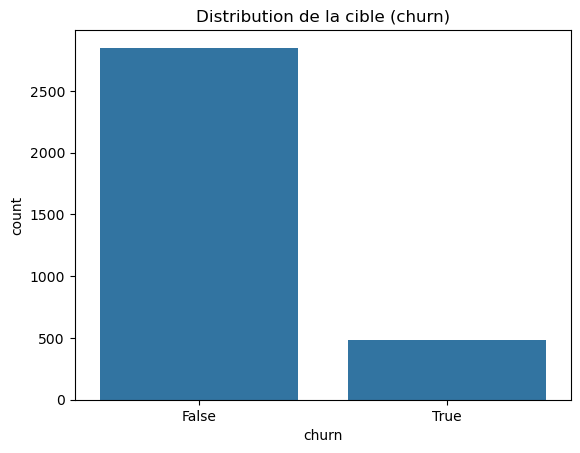

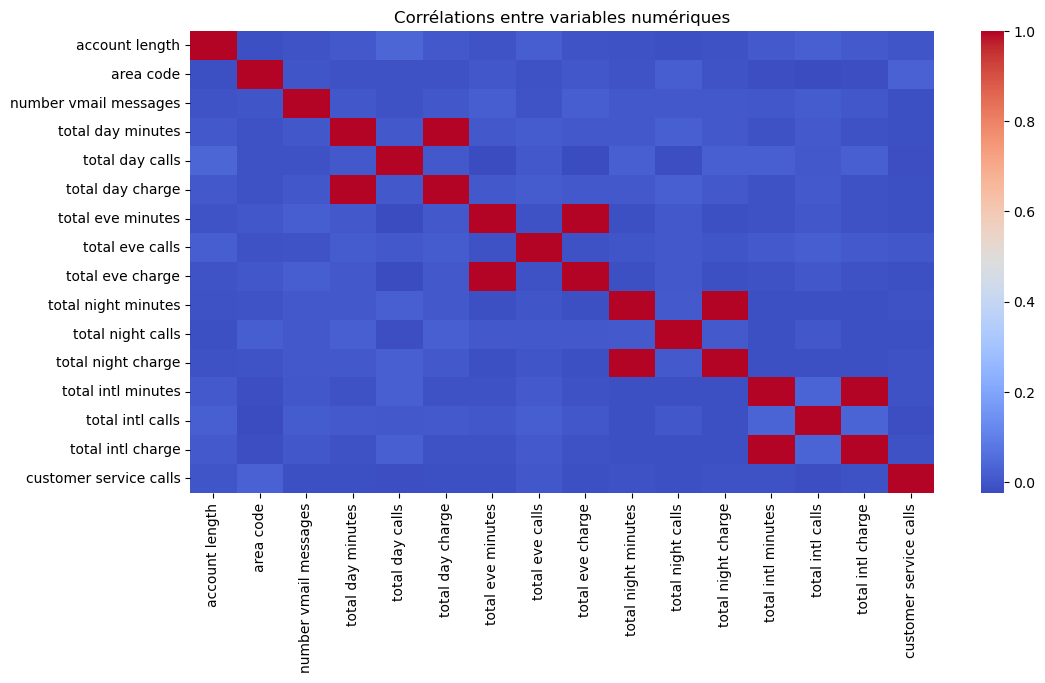

In [34]:
# Vérifier les infos
df.info()

# Statistiques descriptives
df.describe()

# Vérifier les valeurs manquantes
df.isnull().sum()

# Distribution de la variable cible
sns.countplot(x='churn', data=df)
plt.title("Distribution de la cible (churn)")
plt.show()

# Corrélations
# Corrélations (seulement colonnes numériques)
plt.figure(figsize=(12,6))
sns.heatmap(df.select_dtypes(include=["int64","float64"]).corr(), 
            annot=False, cmap="coolwarm")
plt.title("Corrélations entre variables numériques")
plt.show()

# 3) Nettoyage des données

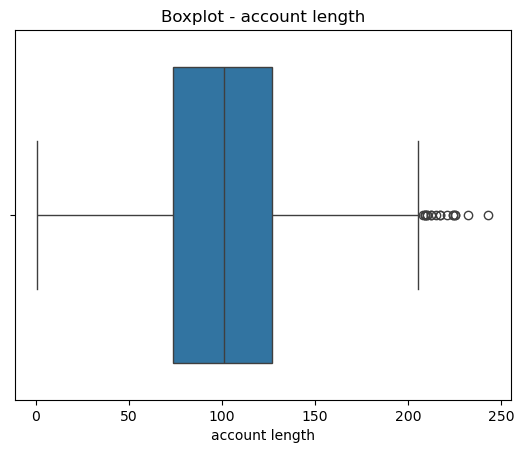

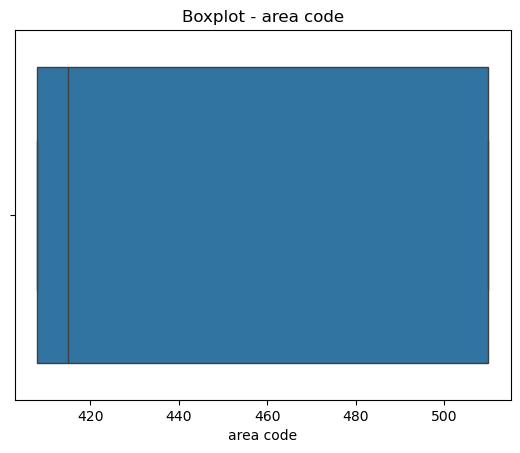

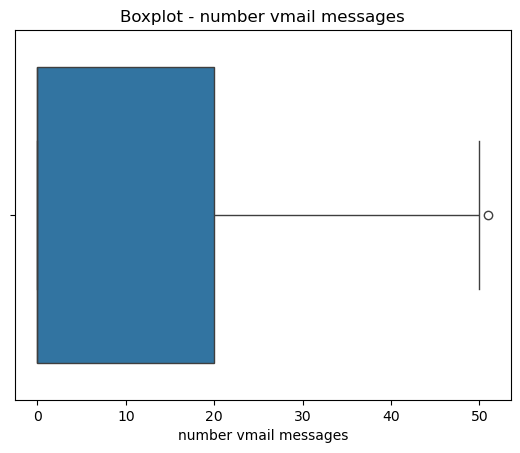

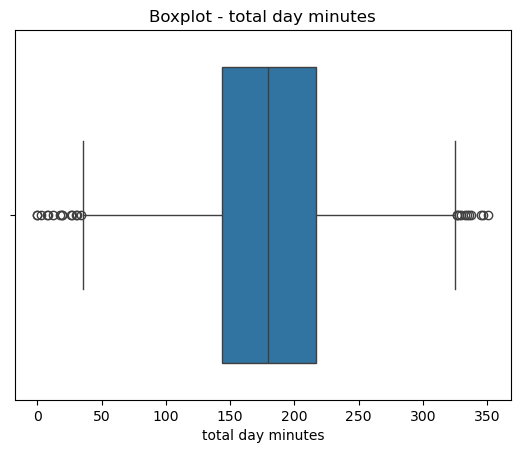

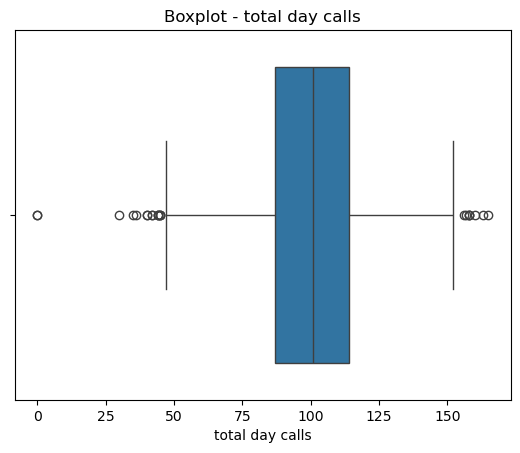

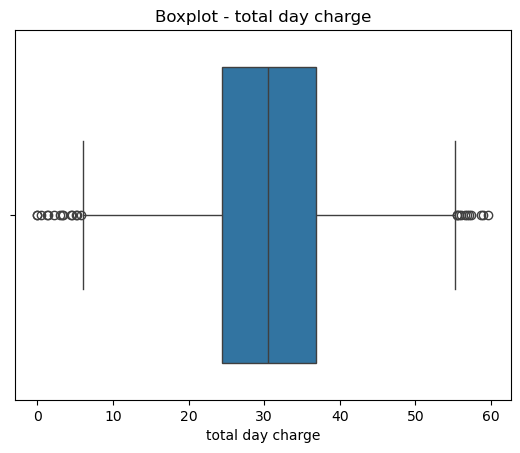

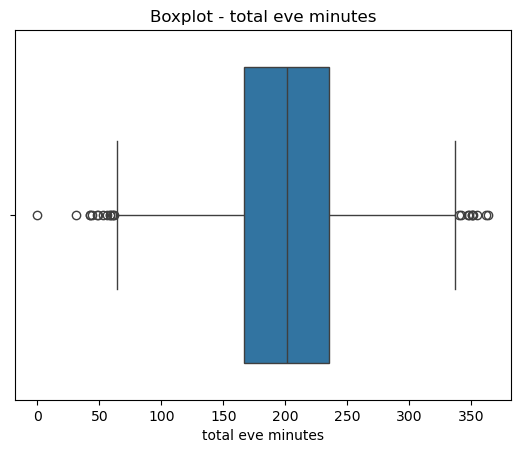

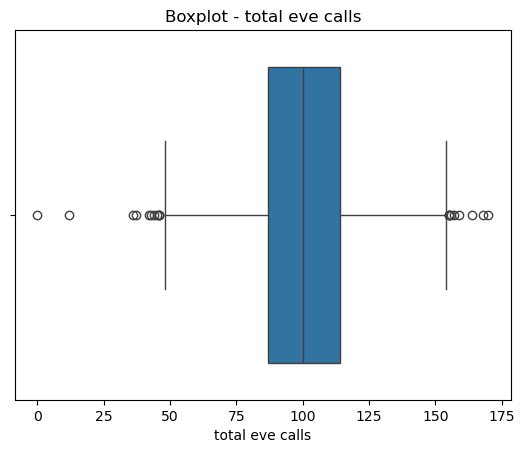

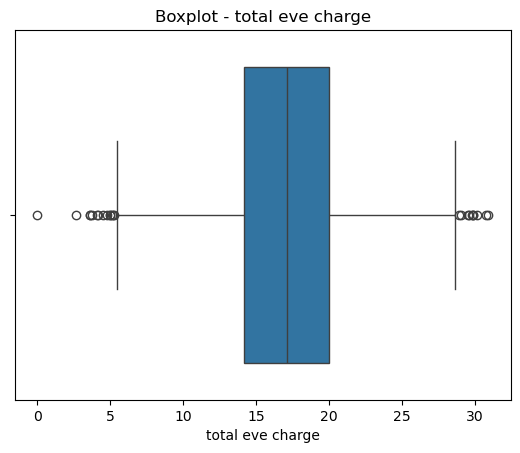

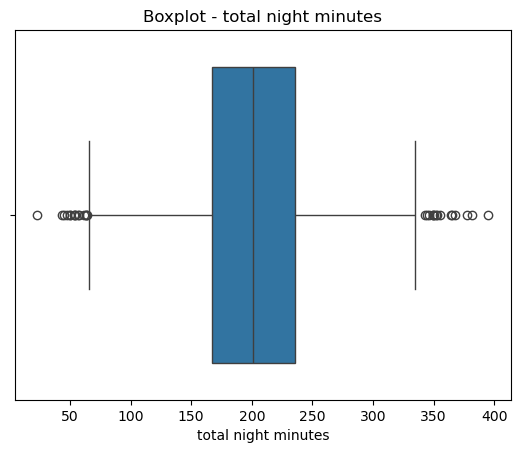

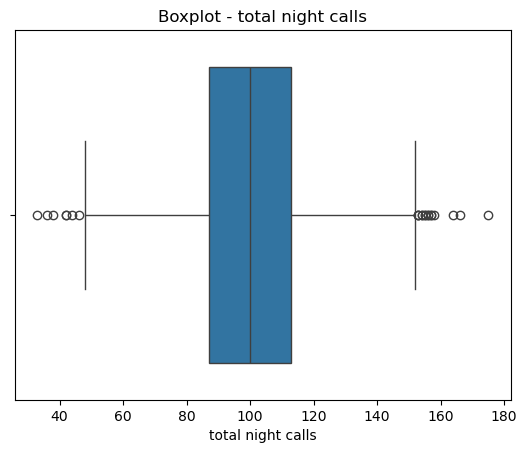

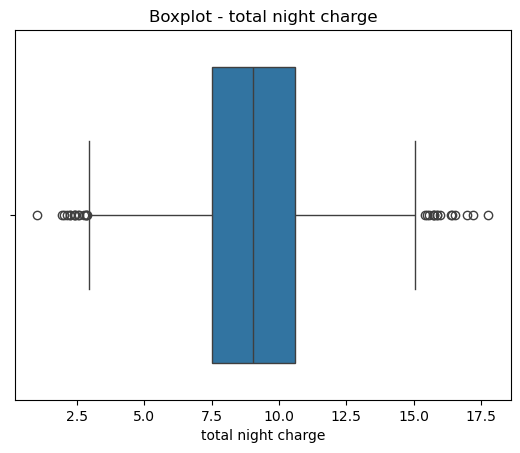

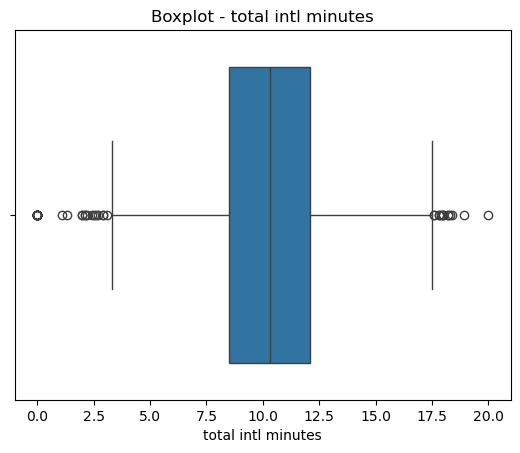

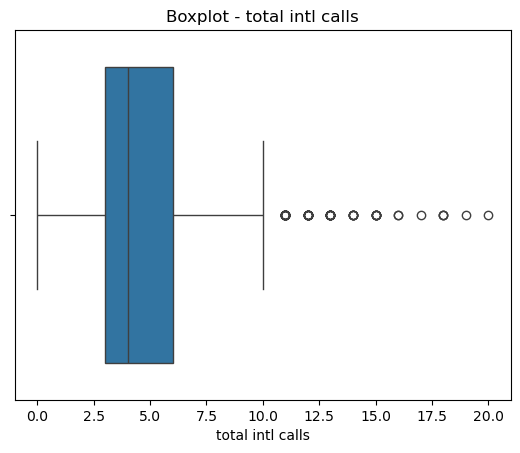

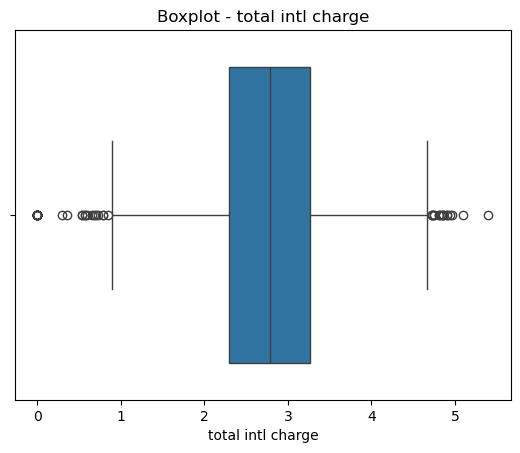

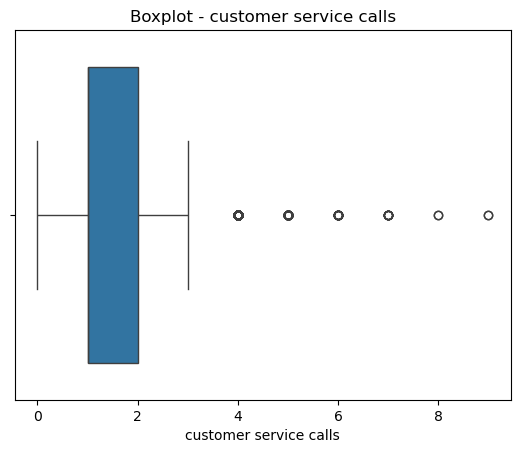

In [35]:
# Nettoyage du dataset

# Doublons
df = df.drop_duplicates()

# Valeurs manquantes
df = df.dropna()

# Détection visuelle des outliers
for col in df.select_dtypes(include=np.number).columns:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot - {col}")
    plt.show()

# 4) Préparation des données

In [36]:
# Encodage des variables catégorielles
df_encoded = pd.get_dummies(df, drop_first=True)

# Séparation features / target
X = df_encoded.drop("churn", axis=1)
y = df_encoded["churn"]

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)

(2333, 3400) (1000, 3400)


# 4) Modélisation

In [37]:
# Pipeline avec scaling + modèle
pipelines = {
    "Logistic Regression": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=1000))]),
    "Decision Tree": Pipeline([("clf", DecisionTreeClassifier(random_state=42))]),
    "Random Forest": Pipeline([("clf", RandomForestClassifier(random_state=42))]),
    "Gradient Boosting": Pipeline([("clf", GradientBoostingClassifier(random_state=42))])
}

# Évaluation basique
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))



=== Logistic Regression ===
              precision    recall  f1-score   support

       False       0.86      1.00      0.92       855
        True       1.00      0.01      0.01       145

    accuracy                           0.86      1000
   macro avg       0.93      0.50      0.47      1000
weighted avg       0.88      0.86      0.79      1000


=== Decision Tree ===
              precision    recall  f1-score   support

       False       0.95      0.98      0.97       855
        True       0.87      0.70      0.77       145

    accuracy                           0.94      1000
   macro avg       0.91      0.84      0.87      1000
weighted avg       0.94      0.94      0.94      1000


=== Random Forest ===
              precision    recall  f1-score   support

       False       0.88      1.00      0.94       855
        True       0.94      0.23      0.38       145

    accuracy                           0.89      1000
   macro avg       0.91      0.62      0.66      1000

# 5)Tuning d’hyperparamètres(exemple RandomForest)

In [38]:
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [5, 10, None]
}

grid = GridSearchCV(pipelines["Random Forest"], param_grid, cv=5, scoring="f1")
grid.fit(X_train, y_train)

print("Meilleurs paramètres:", grid.best_params_)
print("Score F1 (train):", grid.best_score_)

# Évaluation sur test
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

Meilleurs paramètres: {'clf__max_depth': None, 'clf__n_estimators': 200}
Score F1 (train): 0.37945227144702304
              precision    recall  f1-score   support

       False       0.89      1.00      0.94       855
        True       0.95      0.26      0.41       145

    accuracy                           0.89      1000
   macro avg       0.92      0.63      0.68      1000
weighted avg       0.90      0.89      0.86      1000



# 6) Évaluation finale et ROC Curve

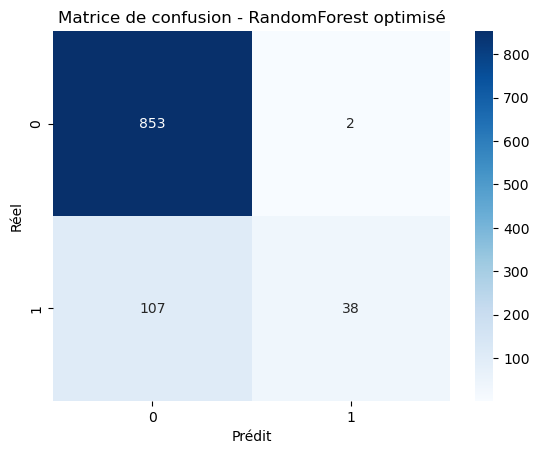

AUC: 0.8993990723936278


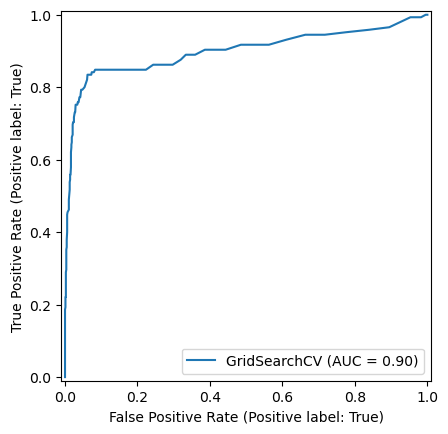

In [42]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - RandomForest optimisé")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# ROC Curve
y_proba = grid.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)
print("AUC:", roc_auc)

RocCurveDisplay.from_estimator(grid, X_test, y_test)
plt.show()

# 7) Interprétation & Importance des variables

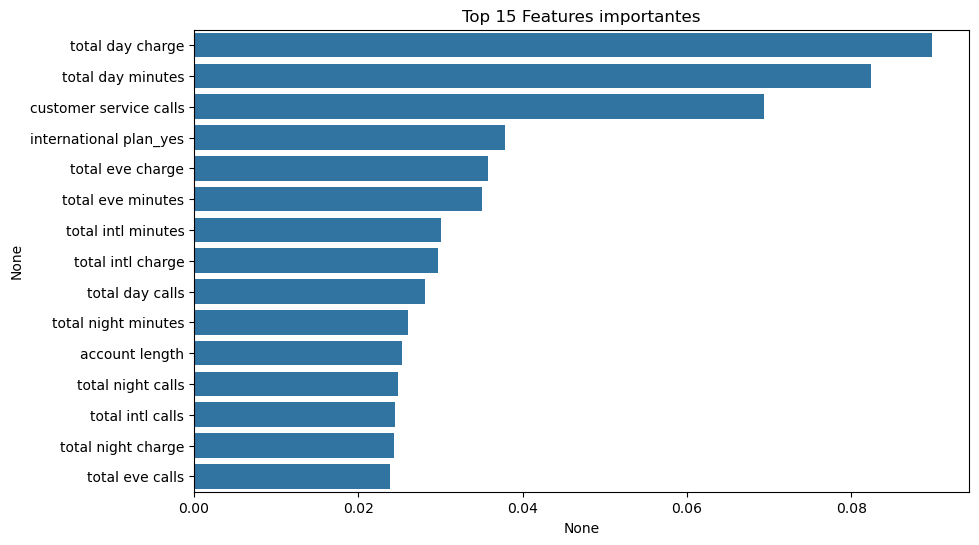

In [43]:
# Importance des features
importances = grid.best_estimator_.named_steps["clf"].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top 15 Features importantes")
plt.show()

# 7) Mes recommandations pour SyriaTel

Après avoir analysé les données et testé notre modèle de classification, voici ce que je propose pour réduire le churn et garder nos clients satisfaits.

##### a) Prioriser les clients à risque

Grâce au modèle, on peut maintenant voir quels clients risquent vraiment de partir. Je recommande de définir un seuil de score de churn (par exemple >0,6) pour identifier ceux sur lesquels il faut agir en priorité. Cela permet de concentrer nos efforts là où ça compte le plus.

##### b) Améliorer le service client

J’ai remarqué que les clients qui appellent souvent le service client sont beaucoup plus susceptibles de churner. Il serait donc stratégique de: Les suivre de près, Résoudre rapidement leurs problèmes, Leur montrer que leur expérience compte pour SyriaTel.

##### c) Offres personnalisées et ajustement des plans

Certains clients, surtout ceux avec un plan international ou une consommation élevée, présentent un risque plus important. Je recommande: De leur proposer des offres adaptées, Des bonus (minutes, data, réductions), Ou des forfaits plus flexibles pour répondre à leurs besoins.

##### d) Fidélisation proactive

Pour les clients à risque mais fidèles, il est essentiel de: Mettre en place un programme de fidélité ou de récompenses, Communiquer régulièrement sur les avantages d’être client SyriaTel, Renforcer leur engagement et augmenter leur valeur sur le long terme. 